## Model Selection

This notebook should include preliminary and baseline modeling.
- Try as many different models as possible.
- Don't worry about hyperparameter tuning or cross validation here.
- Ideas include:
    - linear regression
    - support vector machines
    - random forest
    - xgboost

Consider what metrics you want to use to evaluate success.
- If you think about mean squared error, can we actually relate to the amount of error?
- Try root mean squared error so that error is closer to the original units (dollars)
- What does RMSE do to outliers?
- Is mean absolute error a good metric for this problem?
- What about R^2? Adjusted R^2?
- Briefly describe your reasons for picking the metrics you use

### Linear Regression

In [74]:
# import models and fit
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import ast
import numpy as np

In [75]:
df = pd.read_csv('data/processed/df_scaled.csv')
print(df.dtypes)

tags                     object
permalink                object
status                   object
list_date                object
description              object
branding                 object
lead_attributes          object
property_id               int64
photos                   object
flags                    object
community                object
virtual_tours            object
listing_id              float64
price_reduced_amount    float64
location                 object
matterport                 bool
city                     object
state                    object
Sold Price              float64
sold_price              float64
log_price               float64
dtype: object


In [76]:
# drop rows missing sold_price
df = df.dropna(subset=['sold_price'])

# stringified dict, convert to dict
df['description'] = df['description'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 'sold_price' from 'description' dict
df['sold_price'] = df['description'].apply(lambda d: d.get('sold_price') if isinstance(d, dict) else np.nan)

for col in X.columns:
    if X[col].apply(lambda x: isinstance(x, (dict, list))).any():
        print(f"Column '{col}' contains dict or list values.")

def remove_sold_price(d):
    if isinstance(d, dict):
        d = d.copy()  
        d.pop('sold_price', None) 
    return d

df['description'] = df['description'].apply(remove_sold_price)

# remove 'sold_price' from description
def remove_sold_price(d):
    if isinstance(d, dict):
        d = d.copy()
        d.pop('sold_price', None)
        return d
    return {}

df['description'] = df['description'].apply(remove_sold_price)

In [77]:
low_outliers = df[df['sold_price'] < 10000]
high_outliers = df[df['sold_price'] > 5000000]

print("Low outliers:")
print(low_outliers[['sold_price']].head(5))

print("\nHigh outliers:")
print(high_outliers[['sold_price']].head(5))

Low outliers:
     sold_price
259        9000
300        9000
341        9000
382        9000
423        9000

High outliers:
      sold_price
2347    27065000
2383    27065000
3207    12500000
3248    12500000
3289    12500000


In [ ]:
# expand dict into individual columns
desc_df = df['description'].apply(pd.Series)

# drop original description column
df = df.drop(columns=['description'])

# combine back with original DF
df = pd.concat([df, desc_df], axis=1)

X = pd.get_dummies(df.drop(columns=['sold_price']), drop_first=True)
y = df['sold_price']

# drop rows sold_price NaN first
df = df.dropna(subset=['sold_price'])

# redefine X and y
X = df.drop(columns=['sold_price'])
y = df['sold_price']

# log transform sold_price to normalize distribution, improve model performance, reduce outlier impact
df['sold_price_log'] = np.log1p(df['sold_price'])
y = df['sold_price_log']

In [ ]:
# drop columns 
df = df.drop(columns=['log_price','location','Sold Price','tags','community','branding','permalink', 'status', 'list_date', 'lead_attributes', 'property_id', 'photos', 'flags','virtual_tours', 'listing_id'], errors='ignore')

# final target setup
X = df.drop(columns=['sold_price', 'sold_price_log'])
y = df['sold_price_log']

# drop features
drop_cols = ['name', 'sold_date', 'sub_type', 'state','city', 'baths_1qtr','type']  
X = X.drop(columns=drop_cols, errors='ignore')

# handle features; fill numeric columns with mean
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

# fill categorical/non-numeric columns 
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
X[non_numeric_cols] = X[non_numeric_cols].fillna('missing')
X = pd.get_dummies(X, drop_first=True)

# categorical/text column check matrix X
print(X.select_dtypes(include=['object']).columns)

Index([], dtype='object')


In [ ]:
#feature importance (coefficients) and correlations
coefficients = pd.Series(model.coef_, index=X.columns)
coefficients = coefficients.sort_values(ascending=False)

print("Top positive features:")
print(coefficients.head(10))

print("\nTop negative features:")
print(coefficients.tail(10))


correlations = df.corr(numeric_only=True)['sold_price'].sort_values(ascending=False)
print(correlations)

Top positive features:
baths                   4.050309e-01
matterport              2.588045e-01
price_reduced_amount    1.102677e-01
garage                  2.415518e-02
beds                    3.831102e-03
year_built              9.655586e-05
sqft                    8.925824e-05
lot_sqft               -5.689363e-09
baths_full             -1.423830e-02
baths_3qtr             -4.305433e-02
dtype: float64

Top negative features:
price_reduced_amount    1.102677e-01
garage                  2.415518e-02
beds                    3.831102e-03
year_built              9.655586e-05
sqft                    8.925824e-05
lot_sqft               -5.689363e-09
baths_full             -1.423830e-02
baths_3qtr             -4.305433e-02
stories                -6.991972e-02
baths_half             -5.805720e-01
dtype: float64
sold_price              1.000000
sold_price_log          0.495832
sqft                    0.391824
baths_full              0.374443
baths                   0.268033
beds              

In [ ]:
# split data train and test sets; cleaned y without NaNs 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [82]:
# check model 
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

# evaluate model 
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {mse**0.5:.2f}")
print(f"R² Score (Coefficient of Determination): {r2:.2f}")

Train R²: 0.2747150803655105
Test R²: 0.2778522431588346
Mean Squared Error (MSE): 0.68
Root Mean Squared Error (RMSE): 0.82
R² Score (Coefficient of Determination): 0.28


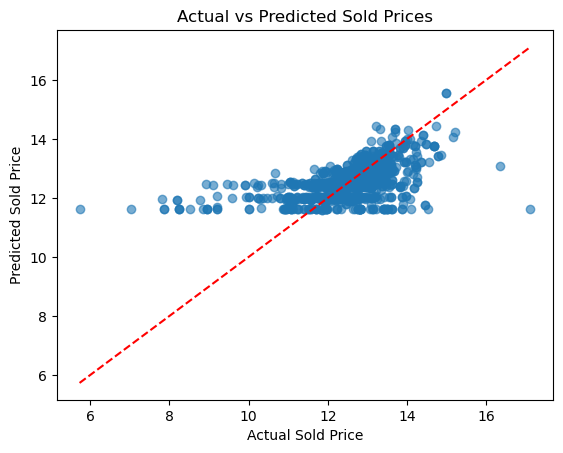

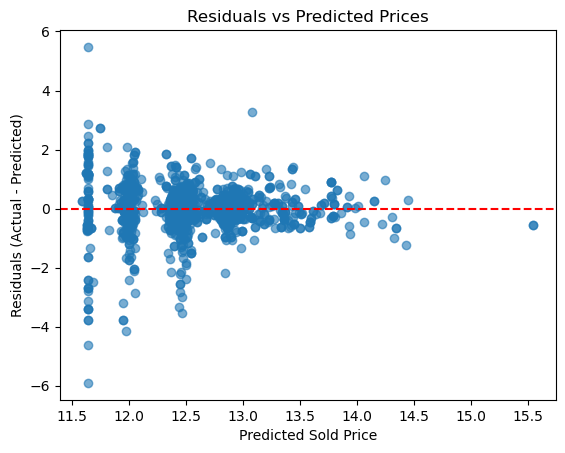

In [83]:
# visualize results Actual vs Predicated prices 
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sold Price")
plt.ylabel("Predicted Sold Price")
plt.title("Actual vs Predicted Sold Prices")
plt.show()

# visualize Residual Plot
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sold Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Prices")
plt.show()

## Random Forest

In [95]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Train on the training data
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Results:")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {mse_rf**0.5:.2f}")
print(f"R² Score: {r2_rf:.2f}")

Random Forest Regressor Results:
Mean Squared Error (MSE): 0.18
Root Mean Squared Error (RMSE): 0.43
R² Score: 0.88


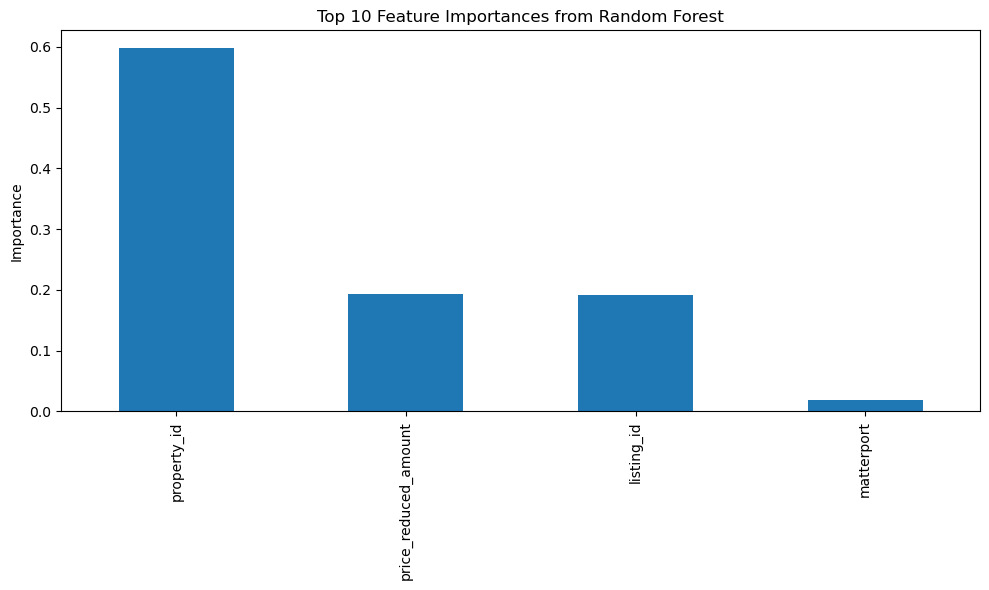

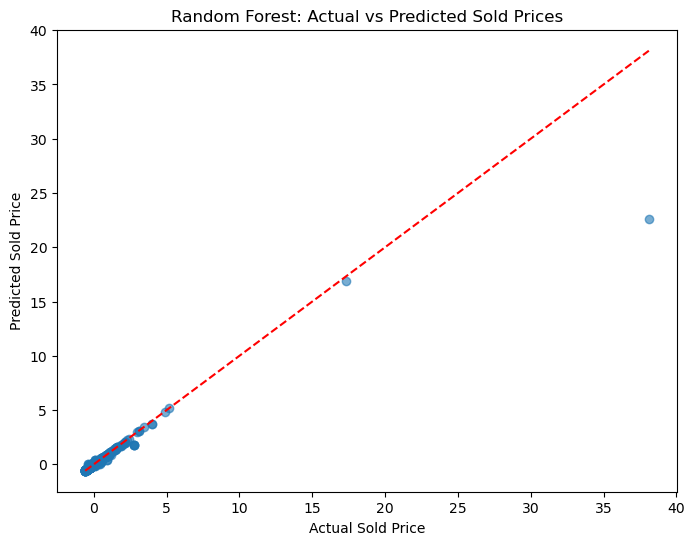

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature importances as a Series sorted descending
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 10 feature importances
plt.figure(figsize=(10,6))
importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted for Random Forest
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sold Price')
plt.ylabel('Predicted Sold Price')
plt.title('Random Forest: Actual vs Predicted Sold Prices')
plt.show()

## XGBoost

In [97]:
#XGBoost

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the regressor
xgb_model = xgb.XGBRegressor(random_state=42, verbosity=0)

# Traincorrelations = X.corrwith(y).sort_values(ascending=False)
print(correlations.head(20))  # Top 20 features most correlated with target
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor Results:")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {mse_xgb**0.5:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

price_reduced_amount    0.197375
matterport              0.065335
listing_id              0.007438
property_id            -0.026937
dtype: float64
XGBoost Regressor Results:
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.20
R² Score: 0.98


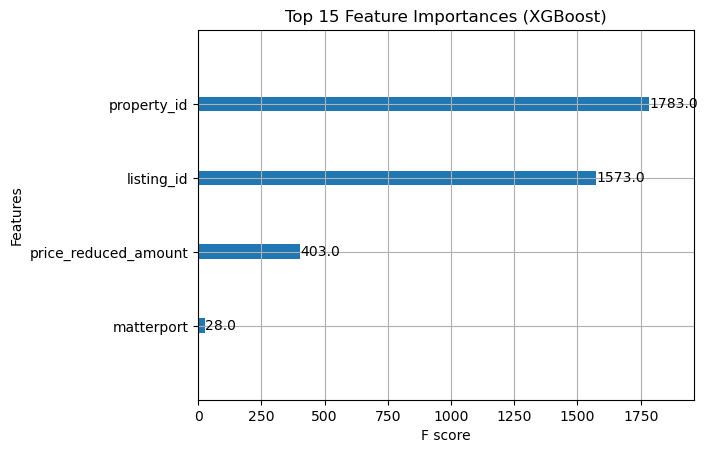

In [98]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, max_num_features=15)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

In [74]:
correlations = X.corrwith(y).sort_values(ascending=False)
print(correlations.head(20))  # Top 20 features most correlated with target

price_reduced_amount    0.197375
matterport              0.065335
listing_id              0.007438
property_id            -0.026937
dtype: float64


## Feature Selection - STRETCH

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its recommended you complete it if you have time!**

Even with all the preprocessing we did in Notebook 1, you probably still have a lot of features. Are they all important for prediction?

Investigate some feature selection algorithms (Lasso, RFE, Forward/Backward Selection)
- Perform feature selection to get a reduced subset of your original features
- Refit your models with this reduced dimensionality - how does performance change on your chosen metrics?
- Based on this, should you include feature selection in your final pipeline? Explain

Remember, feature selection often doesn't directly improve performance, but if performance remains the same, a simpler model is often preferrable. 



In [ ]:
# perform feature selection 
# refit models
# gather evaluation metrics and compare to the previous step (full feature set)